In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Once we get the dataset to be perfectly fine, lets test against different types of k-means clusters 
- Potential suggestion: Explore the dataset to see if there is any form of PCA needed

Find the number of k with the lowest WSS, so that we're able to cluster them accordingly.
After that, we can use the elbow method to find the best k value for the dataset and cluster them accordingly.

After that, we manually analyse the data and from there we are able to then further group the data into two groups.

In [13]:
app = pd.read_csv("application_with_outcome.csv", index_col='Unnamed: 0')

# Check if the data is balanced or not, if it is not we will have to do something to it
app['outcome'].value_counts()

1    343679
0     94878
Name: outcome, dtype: int64

In [14]:
app.head()

,own_car,own_realty,num_child,income,age,years_of_employment,mobile,work_phone,phone,email,...,With parents,Government,Sales,Unemployed,Unknown,has_previous_credit,count_X,count_C,months_late,outcome
0,1,1,0,12.965712,32,12,1,1,0,0,...,0,0,0,0,1,1,1,13,3,1
1,1,1,0,12.965712,32,12,1,1,0,0,...,0,0,0,0,1,1,1,12,3,1
2,1,1,0,11.630717,58,3,1,0,0,0,...,0,0,0,0,1,1,16,7,7,1
3,0,1,0,12.506181,52,8,1,0,1,1,...,0,0,1,0,0,1,3,0,2,1
4,0,1,0,12.506181,52,8,1,0,1,1,...,0,0,1,0,0,1,5,0,0,1


In [15]:
X = app.drop(['outcome'], axis=1)
y = app['outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [16]:
# For each model

# We simplify the training of the model part
def result(X_train, X_test, y_train, model):
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]
    return y_pred

In [17]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter = 5000)
log_reg_result = result(X_train, X_test, y_train, log_reg)
log_reg_result

array([8.20652267e-04, 9.25214066e-01, 9.99523248e-01, ...,
       9.93688200e-01, 9.99994068e-01, 8.58815381e-04])

In [7]:
# Decision Tree 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

dtc = DecisionTreeClassifier()
cross_val_score(dtc, X_train, y_train, cv=10)

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.99996743, 1.        , 0.99996743, 1.        ])

In [8]:
# XG Boost

from xgboost import XGBClassifier
XG_boost = XGBClassifier(n_estimators = 100, learning_rate = 1.0, max_depth = 1, objective="binary:logistic").fit(X_train, y_train)
XG_boost_result = result(X_train, X_test, y_train, XG_boost)
XG_boost_result

array([1.1839567e-06, 1.1839567e-06, 9.9999928e-01, ..., 1.5535777e-06,
       9.9999917e-01, 1.1839567e-06], dtype=float32)

In [9]:
# After we have the result for the few models we're using, we can optimise the hyperparameters to help us find the best model
# For example, we can use GridSearchCV to optimise the hyperparameters for Logistic Regression.
# How do you find the parameters? Documentation

from sklearn.model_selection import GridSearchCV

param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], # learning rate
    # removed solvers: 'newton-cg', 'lbfgs', 
    'solver': ['liblinear', 'sag', 'saga'],
    # removed max_iter values: 100, 1000, 2500, 5000
    'max_iter': [99999]
}

log_reg_cv = GridSearchCV(log_reg, param_grid, cv=3)
log_reg_cv.fit(X_train, y_train)
print(log_reg_cv.best_params_)
print(log_reg_cv.best_score_)

# After that, save this into a model and run result() again
y_pred_logregcv = result(X_train, X_test, y_train, log_reg_cv)
y_pred_logregcv

dtc_cv = GridSearchCV(dtc, param_grid, cv=3)
dtc_cv.fit(X_train, y_train)
print(dtc_cv.best_params_)
print(dtc_cv.best_score_)
y_pred_dtc = result(X_train, X_test, y_train, dtc_cv)
y_pred_dtc

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The ma

After this, we use the ROC AUC score if there is an imbalance in dataset. We try not to use accuracy.

There are also other scores like Precision and Recall, those are usable as well. 

However, let's look at the formulas for precision and recall:
Precision = TP / (TP + FP)
Recall = TP / (TP + FN)

The cost of having a false positive is higher than a false negative as we can deny the loan to a person who is not a defaulter, but we cannot give a loan to a person who is a defaulter.

Therefore we should seek to minimise FP > minimise FN, and therefore the higher the precision, the better.

In [18]:
import matplotlib.pyplot as plt
import numpy as np
# Insert your model here
#model = None
model = log_reg

y_pred = model.predict_proba(X_test)[:, 1]
y_pred

array([8.20652267e-04, 9.25214066e-01, 9.99523248e-01, ...,
       9.93688200e-01, 9.99994068e-01, 8.58815381e-04])

In [19]:
thresholds = np.linspace(0,1,101)

scores = []

for t in thresholds:
    actual_positive = (y_test == 1)
    actual_negative = (y_test == 0)

    pred_positive = (y_pred >= t)
    pred_negative = (y_pred < t)

    tp = (actual_positive & pred_positive).sum()
    tn = (actual_negative & pred_negative).sum()
    fp = (pred_positive & actual_negative).sum()
    fn = (pred_negative & actual_positive).sum()

    scores.append((t, tp, fp, fn, tn))
    
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
scores_data = pd.DataFrame(scores, columns = columns)

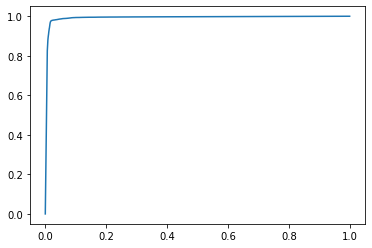

In [22]:
scores_data['tpr'] = scores_data.tp / (scores_data.tp + scores_data.fn)
scores_data['fpr'] = scores_data.fp / (scores_data.fp + scores_data.tn)

plt.plot(scores_data.fpr, scores_data.tpr, label='Model')

# plt.plot(scores_data.threshold, scores_data.tpr, label = 'tpr')
# plt.plot(scores_data.threshold, scores_data.fpr, label = 'fpr')
# plt.legend()

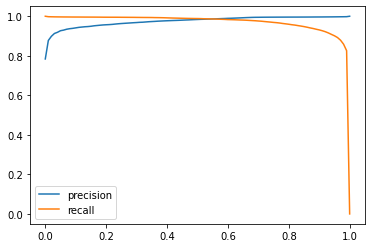

In [21]:
# Make conclusions on the graph pls 

scores_data['precision'] = scores_data.tp / (scores_data.tp + scores_data.fp)
scores_data['recall'] = scores_data.tp / (scores_data.tp + scores_data.fn)

plt.plot(scores_data.threshold, scores_data.precision, label = 'precision')
plt.plot(scores_data.threshold, scores_data.recall, label = 'recall')
plt.legend()